In [1]:
import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

%matplotlib inline

Using TensorFlow backend.
/home/watiz/.virtualenvs/siamese_reid/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class args:
    save_dir = "weights/"
    debug = True

    # model
    routings = 1

    # hp
    batch_size = 32
    lr = 0.001
    lr_decay = 1.0
    lam_recon = 0.392

    # training
    epochs = 3
    shift_fraction = 0.1
    digit = 5

In [3]:

def CapsNet(input_shape, n_class, routings):
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)
    
    model = models.Model(x, out_caps)
    
    return model


In [4]:
# the data, shuffled and split between train and test sets
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = to_categorical(y_train.astype('float32'))
y_test = to_categorical(y_test.astype('float32'))

x_train = x_train[:1000]
y_train = y_train[:1000]
x_test = x_test[:1000]
y_test = y_test[:1000]


In [5]:
def margin_loss(y_true, y_pred):
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))


In [6]:
model = CapsNet(input_shape=x_train.shape[1:], n_class=len(np.unique(np.argmax(y_train, 1))), routings=args.routings)

In [7]:
model.compile(optimizer=optimizers.Adam(lr=args.lr), loss=[margin_loss])

In [8]:
model.fit(x_train, y_train, validation_data=[x_test, y_test], epochs=3)

Train on 1000 samples, validate on 1000 samples
Epoch 1/3
1000/1000 [==============================] - 20s - loss: 0.4622 - val_loss: 0.2460
Epoch 2/3
1000/1000 [==============================] - 20s - loss: 0.1756 - val_loss: 0.1639
Epoch 3/3
1000/1000 [==============================] - 26s - loss: 0.1070 - val_loss: 0.1050


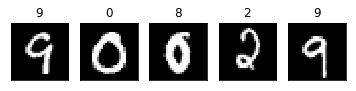

In [9]:
n_images = 5
ids = np.random.choice(x_test.shape[0], n_images, replace=False)
images = x_test[ids]
id_class = model.predict(images)

for index, image in enumerate(images):
    ax = plt.subplot(1, n_images, index+1)
    plt.imshow(image.reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax.set_title("{0}".format(np.argmax(id_class[index])))